In [19]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

In [7]:
data = pd.read_excel('credit_defaults.xlsx', sheet_name='credit_defaults.csv', header=1)
data['default'] = data['default payment next month']
data = data.drop('default payment next month', axis=1)

In [8]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Dataset Description

In [9]:
data['SEX'].value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

In [10]:
data['EDUCATION'].value_counts()
# 0, 5, 6 not explained in dataset desc

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

<p> <b> Labels 0, 5, and  6 are not explained in the dataset description </b></p>

In [11]:
data['MARRIAGE'].value_counts()
# 0 not in desc

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

<b> 0 not explained in dataset</b>

## Data Exploration

### Checking for Class Imbalance

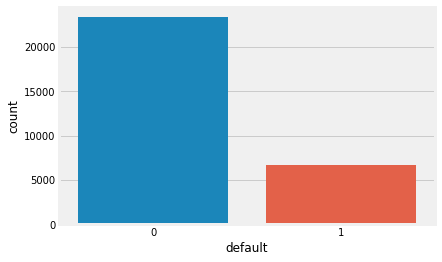

In [12]:
# Checking for Class Imbalance
sns.countplot(x = data['default'])

### Distribution of Age among Non-Defaulters and Defaulters

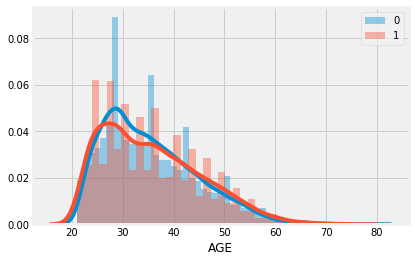

In [13]:
sns.distplot(data['AGE'][data['default']==0])
sns.distplot(data['AGE'][data['default']==1])
plt.legend(['0', '1'])


### Education Levels of Default vs Non-Default

(0, 11000)

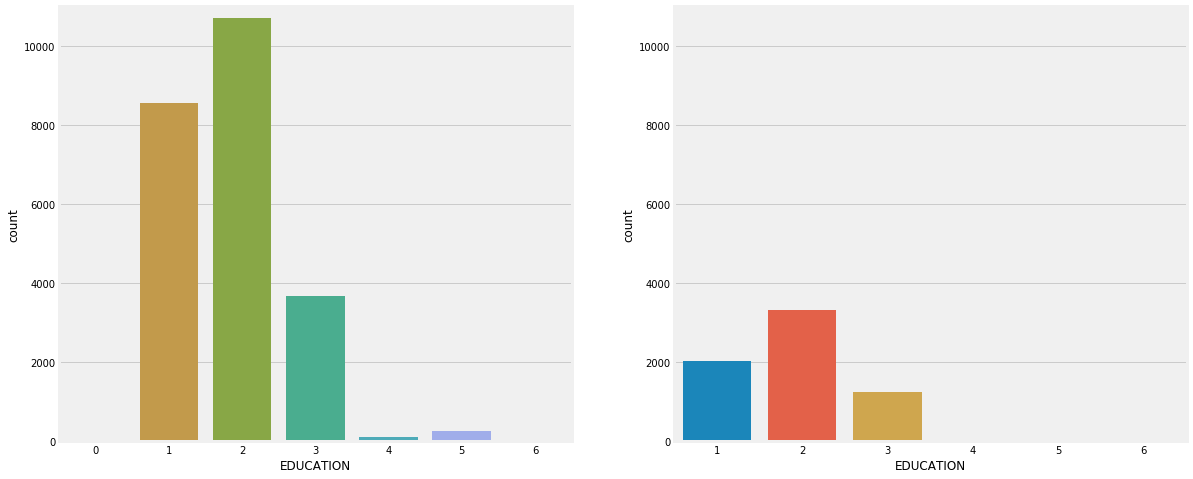

In [14]:
f, ax = plt.subplots(1,2,figsize =(18,8))
sns.countplot(x = data['EDUCATION'][data['default']==0], ax=ax[0])
sns.countplot(x = data['EDUCATION'][data['default']==1], ax=ax[1])
ax[0].set_ylim(0,11000)
ax[1].set_ylim(0,11000)

### Credit Limit Distribution

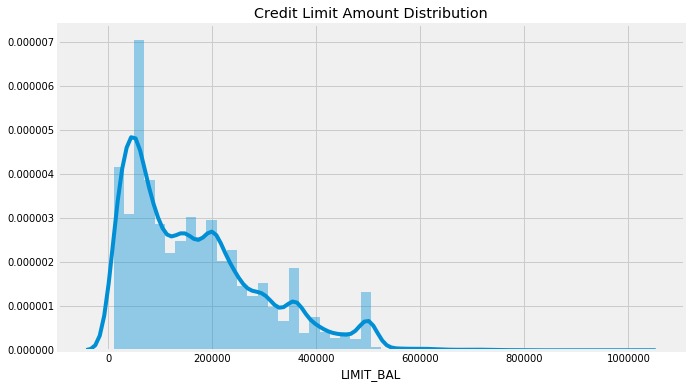

In [15]:
plt.figure(figsize = (10,6))
plt.title("Credit Limit Amount Distribution")
sns.distplot(data['LIMIT_BAL'])

### Credit Limit and Sex

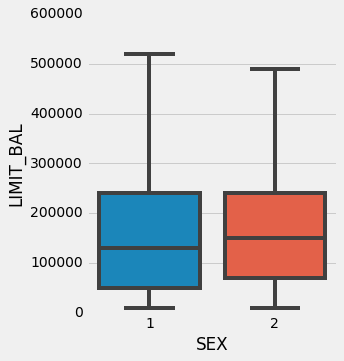

In [209]:
matplotlib.style.use('fivethirtyeight')
plt.figure(figsize = (4,5))
sns.boxplot(data = data, x = 'SEX', y='LIMIT_BAL', showfliers=False)

## Correlation Heatmap

### Pay Correlation

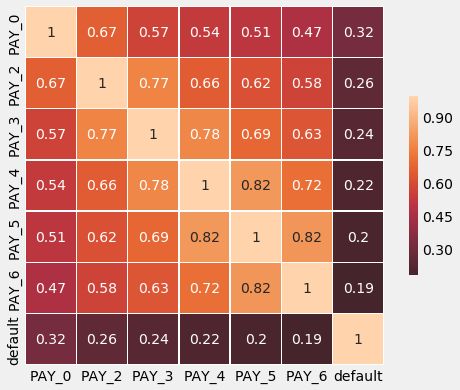

In [210]:
pay_f = data[['PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'default']]
corr = pay_f.corr()

f, ax = plt.subplots(figsize=(8, 6))

# Generate a mask for the upper triangle
#mask = np.zeros_like(corr, dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, annot=True, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
#sns.heatmap(corr)
#pay_f.head()

The status of each pay period seems to have a good correlation with every other pay period. The also seems to have a low correlation with the 'default' status. This could probably be used during the Feature Engineering process to extract new features from the features of Pay Status.

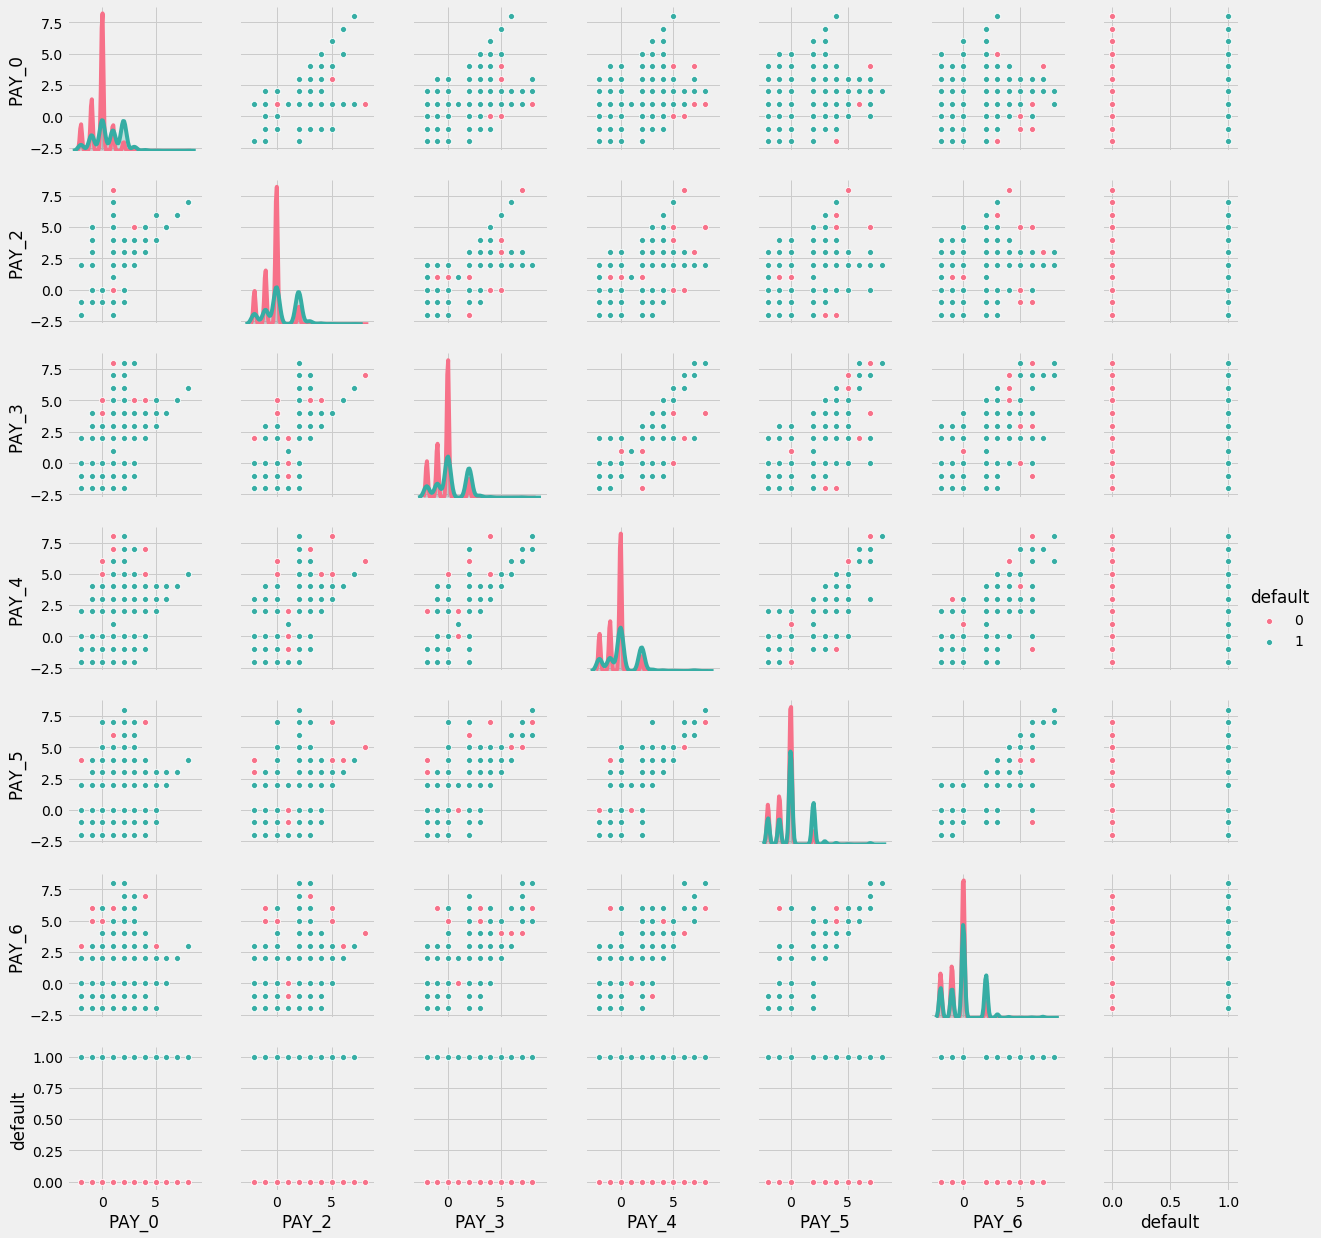

In [20]:
sns.pairplot(pay_f, palette="husl", hue='default')

As seen previously in the correlation heatmap, the pairplot shows an alternate visual representation of the seeming linear relationships among the pay status features.

### Bill Amount Correlation

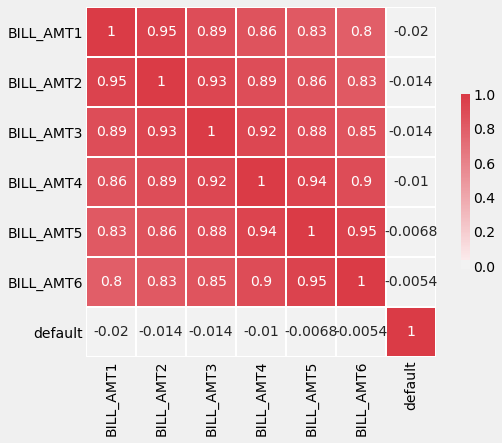

In [21]:
bill_f = data[['BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'default']]
corr = bill_f.corr()

f, ax = plt.subplots(figsize=(8, 6))

# Generate a mask for the upper triangle
#mask = np.zeros_like(corr, dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, annot=True, cmap=cmap, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
#sns.heatmap(corr)
#pay_f.head()

Each month's billing amount seems to be highly correlated with every other month's billing amount. The correlation is much higher among each when compared to monthly pay status, however, billing amount does have a slightly negative correlation with default status as compared to the correlation between pay status and default. 

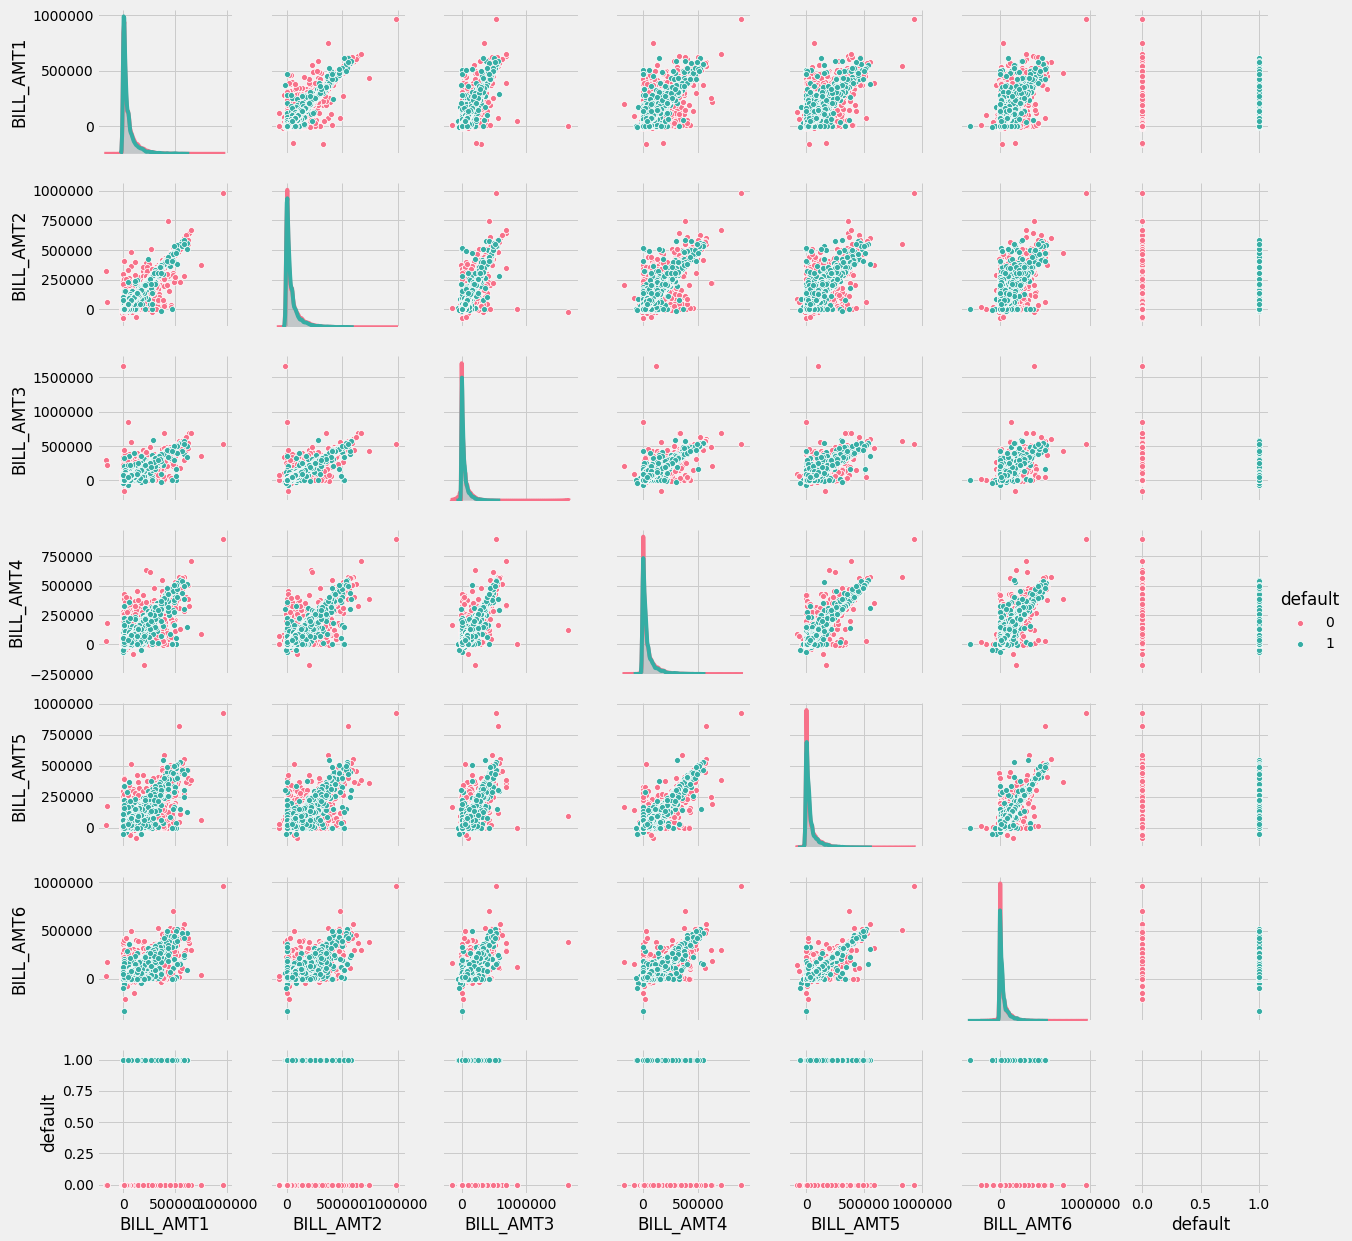

In [22]:
sns.pairplot(bill_f, palette="husl", hue='default')

As indicated in the heatmap, the relationships here are more linear as compared to the 'PAY_N'-'default' correlation. 




The insights from correlations about 'Pay_N' - 'default' and 'BILL_AMTN' - 'default' seem helpful in extracting new features for the feature engineering process. 

# Feature Engineering

There are going to be two parts in the Feature Engineering process.

1. Feature Creation - We supplement the dataset with new features from external data sources that help give more context to the original dataset. 
2. Feature Transformation - We create features by trying to extract more information within the dataset by making certain relationships or factors explicit.



### Feature Creation
The data in the dataset is from Taiwan in 1995

** 1. Rent = TWD 14514 **


Average rent of a one bedroom apartment in Taiwan costs TWD14,514.

<b>Assumption 1:</b> If a person is single, they have their own house and there is no roommate arrangement that splits costs. 

<p><b>Assumption 2:</b> If a person is married, they still live in a one bedroom apartment and not a two bedroom which obviously costs more. Also, this scenario does not account for number of children, which may lead to a married couple having a higher chance of living in a 1+ bedroom house. 
</p>

<p>One rough way to tackle the shortcomings of assumption 2 is to know the percentage of married people living in 1+ bedroom houses and then randomly assign the costs to ous dataset covering a distribution. Say, 60% of couples live in 2 bedroom houses, the we apply (Rent of 2 Bedroom APT) to 60% of the people in our dataset but this itself may skew the dataset is it does not make intuitive sense for certain observation who defaults as a person with a low credit score may not be able to lease a house. So maybe accounting for more datapoints like a simulated credit score could help but we will not use it in this analysis. </p>


** 2. Restaurant =  TWD 1400 **

<p>The average person goes to a restaurant atleast every 6 weeks[]. They spend an average of TWD 350 during each visit. We have credit data that has over 6 months. During the six months, a person eats an average 4 times at restaurants. So over a period of six months, a single person spends 4 * TWD 350 = TWD 1400. A married couple, will spend twice that, which is TWD 2800.</p>

<p><b> Assumption: </b> Every person pays for himself/herself unless they are married. Single person cost = 1400 and Married couple cost = 1400 * 2.  </p>

** 3. Food = TWD 29400 **

<p>Based on my rough personal estimates, cost of 3 home cooked meals cost equals quater the cost of a single meal at a restaurant. Using, previous restaurant data, each day's groceries may cost, TWD 175. 6 months food costs = 6 * 4 * 7 * 175 = TWD 29400. This amount seems comparable to the list of groceries prices in following source[1].</p>

** 4. Other Costs of Living = TWD 27795 **

<p>Costs such as Electricity, Water, Gas, Internet, Transportation = TWD 4633 per month. </p>



### Feature Transformation

** 5. Total Bill Amount = Sum of all  bill amount to be paid **


** 6. Total Pay Amount = Sum of all amount paid **


** 7. Total Bill Amt - Total Pay **


** 8. Limit Balance - (Total Bill Amt - Total Pay) **


** 9. Ratio = (Limit Balance) / (Total Bill Amt - Total Pay) **

In [213]:
fe_data = data.copy(deep=True)

In [214]:
def food(row):
    if(row['MARRIAGE'] == 1):
        return (29400 * 2)
    else:
        return 29400

def res(row):
    if(row['MARRIAGE'] == 1):
        return (1400 * 2)
    else:
        return 1400

fe_data['RENT'] = 14514
fe_data['FOOD'] = fe_data.apply(food, axis=1)
fe_data['RESTAURENT'] = fe_data.apply(res, axis=1)
fe_data['COST_OF_LIVING'] = 27795
fe_data['TOTAL_BILL_AMT'] = fe_data['BILL_AMT1'] + fe_data['BILL_AMT2'] + fe_data['BILL_AMT3'] + fe_data['BILL_AMT4'] + fe_data['BILL_AMT5'] + fe_data['BILL_AMT6']
fe_data['TOTAL_PAY_AMT'] = fe_data['PAY_AMT1'] + fe_data['PAY_AMT2'] + fe_data['PAY_AMT3'] + fe_data['PAY_AMT4'] + fe_data['PAY_AMT5'] + fe_data['PAY_AMT6']
fe_data['TOTAL BILL - PAY'] = fe_data['TOTAL_BILL_AMT'] - fe_data['TOTAL_PAY_AMT']
fe_data['LIMIT_BAL - TBM'] = fe_data['LIMIT_BAL'] - fe_data['TOTAL BILL - PAY']
fe_data['LB/TBM'] = fe_data['LIMIT_BAL']/fe_data['TOTAL BILL - PAY']




In [215]:
fe_data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,RENT,FOOD,RESTAURENT,COST_OF_LIVING,TOTAL_BILL_AMT,TOTAL_PAY_AMT,TOTAL BILL - PAY,LIMIT_BAL - TBM,LB/TBM
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,14514,58800,2800,27795,7704,689,7015,12985,2.851033
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,14514,29400,1400,27795,17077,5000,12077,107923,9.936242
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,14514,29400,1400,27795,101653,11018,90635,-635,0.992994
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,14514,58800,2800,27795,231334,8388,222946,-172946,0.224270
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,14514,58800,2800,27795,109339,59049,50290,-290,0.994233


## Data Preparation

In [23]:
#data = data.drop('ID', axis=1)
d1 = pd.get_dummies(data, columns = ['SEX', 'EDUCATION', 'MARRIAGE'])
d1.head()

,ID,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,1,20000,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0
1,2,120000,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0,1,0,0,1,0,0,0,0,0,0,1,0
2,3,90000,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0,1,0,0,1,0,0,0,0,0,0,1,0
3,4,50000,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0,1,0,0,1,0,0,0,0,0,1,0,0
4,5,50000,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,1,0,0,0,1,0,0,0,0,0,1,0,0


In [24]:
X = d1.drop('default', axis=1)
y = d1['default']
print(X.shape)
print(y.shape)

(30000, 34)
(30000,)


## Machine Learning Model

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn import metrics

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 4)

## Evaluation Metric

We will use the recall score also known as sensitivity as an evaluation metric because for this particular problem, the business context of a bank makes clear it is more important to know who will default rather than who will not. In other words, it is ok if we classify a few non-defaulters as potential defaulters rather then classifying actual defaulters as non-defaulters. Non-defaulter who get classified as defaulters (False Positives) may have to go through additional scrutiny or file more info to continue transactions. Also, False Positives will be more willing to cooperate during additional scrutiny if they and the bank believe they have a good change for not having a reason to be a potential defaulter. 

We will try to reduce the false positives throughout the process based on different algorithms, tuning procedures, and thresholding techniques. 

### Logistic Regression

In [35]:
penalty_type = ['l1', 'l2']
C_value = [0.001,0.01,0.1,0.5,1]
scoring_metrics = ['recall']

logreg = LogisticRegression()
param_grid = dict(penalty=penalty_type, C=C_value)
grid = GridSearchCV(logreg, param_grid, cv=10, scoring='recall')
grid.fit(X,y)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [36]:
grid.best_params_, grid.best_score_

({'C': 1, 'penalty': 'l1'}, 0.23899221789117253)

In [39]:
logreg.fit(X_train, y_train)
y_pred_proba_logreg = logreg.predict_proba(X_test)[:,1]


## Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rfc = RandomForestClassifier()
scores = cross_val_score(rfc, X, y, cv=10, scoring='recall')
print(scores)
print(scores.mean())

[0.24246988 0.29216867 0.31024096 0.30722892 0.32078313 0.39457831
 0.36651584 0.29713424 0.29562594 0.34690799]
0.3173653891584437


In [41]:
rfc.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>

In [42]:
rfc.fit(X_train, y_train)
y_pred_proba_rfc = rfc.predict_proba(X_test)[:,1]


## AdaBoost

In [43]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier()
scores = cross_val_score(ada, X, y, cv=10, scoring='recall')
print(scores)
print(scores.mean())

[0.29518072 0.30120482 0.31626506 0.30421687 0.3253012  0.38554217
 0.30015083 0.22775264 0.3107089  0.0015083 ]
0.27678315070235693


In [44]:
ada.fit(X_train, y_train)
y_pred_proba_ada = ada.predict_proba(X_test)[:,1]


## GradientBoostingClassifier

In [222]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

gbc = GradientBoostingClassifier()
scores = cross_val_score(gbc, X, y, cv=10, scoring='recall')
print(scores)
print(scores.mean())

[0.75301205 0.34186747 0.375      0.33433735 0.24096386 0.5060241
 0.18552036 0.3453997  0.33031674 0.3800905 ]
0.3792532119427938


In [223]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred_proba_gbc = gbc.predict_proba(X_test)[:,1]

## ROC Curve

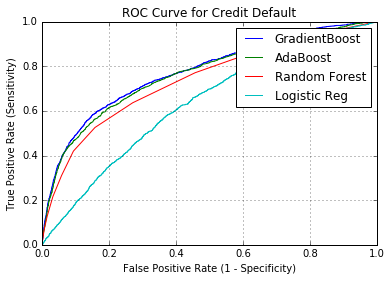

In [224]:
#import matplotlib
plt.subplots(figsize=(40,22))
matplotlib.style.use('classic')
#f, ax = plt.subplots(1,2,figsize =(18,8))
%matplotlib inline
plt.xlim(0,1)
plt.ylim(0,1)
#fig = plt.gcf()
#fig.set_size_inches(8,7)
plt.title("ROC Curve for Credit Default")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.grid(True)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba_gbc)
plt.plot(fpr, tpr)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba_ada)
plt.plot(fpr, tpr)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba_rfc)
plt.plot(fpr, tpr)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba_logreg)
plt.plot(fpr, tpr)
plt.legend(['GradientBoost','AdaBoost','Random Forest','Logistic Reg'])


In [53]:
print("AUC of Gradient Boosting Algorithm: ", metrics.roc_auc_score(y_test,y_pred_proba_gbc))

AUC of Gradient Boosting Algorithm:  0.7754158295362534


We can notice here that the Gradient Boosting Algorithm has the best ROC curve among the other algorithms. We will choose that for further Model Thresholding and Tuning.

## Adjusting Model Threshold

In this step, we will try to adjust the threshold of the gradient boosting classifier in such a way that it can increase the sensitivity of the model without adversely affecting the accuracy or the specificity values.

In [181]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
print(metrics.recall_score(y_test, y_pred))
print(metrics.accuracy_score(y_test,y_pred))

#gbc.predict_proba(X_test)

0.3629366489046773
0.8174666666666667


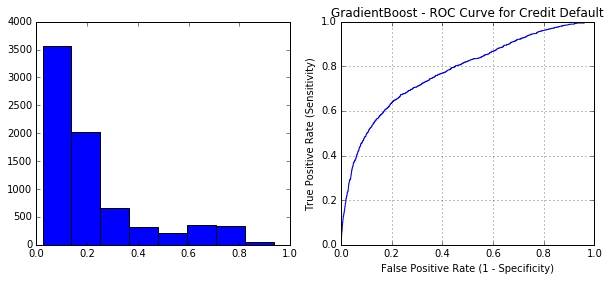

In [182]:
y_pred_proba = gbc.predict_proba(X_test)[:,1]

import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(1, 2,  figsize=(10,4))
#f1 = plt.figure(1)
ax[0].hist(y_pred_proba, bins = 8)
plt.xlim(0,1)
#f1.show()

#f2 = plt.figure(2)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba_gbc)
plt.title("GradientBoost - ROC Curve for Credit Default")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid(True)
ax[1].plot(fpr, tpr)
plt.show()

In the first graph on the left, we notice that most of the credit default happen before 0.5 probability. By default, the Gradient Boosting Classifier has the threshold at 0.50. We can increase the sensitivity of the classifier by reducing the threshold and bringing it to the left. 

Now, the more we bring it to the left, the higher the specificity value increases, or we need to find an acceptable tradeoff. 

On the graph right side, we can see the amount of specificity we can expect for a certain level of specificity. There is a handy function below called evaluate_threshold that calculates the tradeoff values.

In [177]:
from sklearn.preprocessing import binarize
y_pred_class = binarize([y_pred_proba], 0.25)[0]
#y_pred_class
print('Null Value Accuracy: ', 1 - data['default'].mean())
print('Accuracy Score: ', metrics.accuracy_score(y_test,y_pred_class))
print('Sensitivity Score: ', metrics.recall_score(y_test, y_pred_class))

Null Value Accuracy:  0.7787999999999999
Accuracy Score:  0.7813333333333333
Sensitivity Score:  0.5855535820011841


### Sensitivity and Specificity Trade-off

In [169]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba_gbc)
# A function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [170]:
evaluate_threshold(0.21)

Sensitivity: 0.6530491415038484
Specificity: 0.7807606263982103


By setting a threshold of 0.21, the amount of sensitivity is 0.653 and specificity is 0.780. 

# Tuning Gradient Boosting

In [89]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 4)

### Base Model

Running a baseline model with default parameter values.

In [132]:
from sklearn.model_selection import cross_val_score
#gbc = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100, min_samples_split = 150, min_samples_leaf = 1, max_depth=5, max_features='sqrt', subsample=0.8)
gbc = GradientBoostingClassifier()
scores = cross_val_score(gbc, X, y, cv=10, scoring='recall')
print(scores)
print(scores.mean())

[0.6686747  0.33433735 0.36746988 0.32228916 0.35843373 0.48493976
 0.22322775 0.3438914  0.32880845 0.41176471]
0.3843836886005561


## Tuning Order in terms of Maximum Impact
1. Number of Estimators
2. max_depth and num_samples-split
3. min_samples leaf
4. max_features
5. Tuning subsample value
6. Lowering Learning Rate and Re-Tuning Estimators
7. Halving Learning Rate and 2x Increasing Estimators

### Tuning Number of Estimators

In [92]:
from sklearn.model_selection import GridSearchCV
n_estimator_range = range(240, 350, 10)
param_grid = dict(n_estimators = n_estimator_range)
grid =GridSearchCV(gbc,param_grid, cv=10, scoring='recall', n_jobs=-1)

In [93]:
grid.fit(X,y)
grid.grid_scores_, grid.best_params_, grid.best_score_


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.39585, std: 0.13703, params: {'n_estimators': 240},
  mean: 0.38407, std: 0.14749, params: {'n_estimators': 250},
  mean: 0.41587, std: 0.15792, params: {'n_estimators': 260},
  mean: 0.38543, std: 0.15675, params: {'n_estimators': 270},
  mean: 0.39688, std: 0.16872, params: {'n_estimators': 280},
  mean: 0.39915, std: 0.15384, params: {'n_estimators': 290},
  mean: 0.38076, std: 0.16547, params: {'n_estimators': 300},
  mean: 0.41134, std: 0.19827, params: {'n_estimators': 310},
  mean: 0.38618, std: 0.16366, params: {'n_estimators': 320},
  mean: 0.37474, std: 0.14219, params: {'n_estimators': 330},
  mean: 0.37172, std: 0.15926, params: {'n_estimators': 340}],
 {'n_estimators': 260},
 0.4158734143209337)

### Tuning max_depth and num_samples_split

In [95]:
from sklearn.grid_search import RandomizedSearchCV
md_range = range(1, 11, 1)
msp_range = range(100,300, 50)
param_grid = dict(max_depth = md_range, min_samples_split = msp_range)
grid = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=260, max_features='sqrt', subsample=0.8, random_state=4), param_grid = param_grid, scoring='recall', n_jobs=-1, cv = 10)
#grid = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=340, max_features='sqrt', subsample=0.8, random_state=4), param_grid = param_grid, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
grid.fit(X,y)
grid.grid_scores_, grid.best_params_, grid.best_score_

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  Deprecatio

([mean: 0.34026, std: 0.06340, params: {'max_depth': 1, 'min_samples_split': 100},
  mean: 0.34026, std: 0.06340, params: {'max_depth': 1, 'min_samples_split': 150},
  mean: 0.34026, std: 0.06340, params: {'max_depth': 1, 'min_samples_split': 200},
  mean: 0.34026, std: 0.06340, params: {'max_depth': 1, 'min_samples_split': 250},
  mean: 0.40083, std: 0.13949, params: {'max_depth': 2, 'min_samples_split': 100},
  mean: 0.39631, std: 0.13103, params: {'max_depth': 2, 'min_samples_split': 150},
  mean: 0.39691, std: 0.12819, params: {'max_depth': 2, 'min_samples_split': 200},
  mean: 0.40278, std: 0.14523, params: {'max_depth': 2, 'min_samples_split': 250},
  mean: 0.38981, std: 0.13022, params: {'max_depth': 3, 'min_samples_split': 100},
  mean: 0.39373, std: 0.12735, params: {'max_depth': 3, 'min_samples_split': 150},
  mean: 0.40534, std: 0.14393, params: {'max_depth': 3, 'min_samples_split': 200},
  mean: 0.41046, std: 0.15283, params: {'max_depth': 3, 'min_samples_split': 250},
  me

In [96]:
from sklearn.grid_search import RandomizedSearchCV
md_range = range(1, 11, 1)
msp_range = range(50,101, 50)
param_grid = dict(max_depth = md_range, min_samples_split = msp_range)
grid = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=260, max_features='sqrt', subsample=0.8, random_state=4), param_grid = param_grid, scoring='recall', n_jobs=-1, cv = 10)
#grid = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=340, max_features='sqrt', subsample=0.8, random_state=4), param_grid = param_grid, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
grid.fit(X,y)
grid.grid_scores_, grid.best_params_, grid.best_score_

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.34026, std: 0.06340, params: {'max_depth': 1, 'min_samples_split': 50},
  mean: 0.34026, std: 0.06340, params: {'max_depth': 1, 'min_samples_split': 100},
  mean: 0.39826, std: 0.13956, params: {'max_depth': 2, 'min_samples_split': 50},
  mean: 0.40083, std: 0.13949, params: {'max_depth': 2, 'min_samples_split': 100},
  mean: 0.39599, std: 0.13849, params: {'max_depth': 3, 'min_samples_split': 50},
  mean: 0.38981, std: 0.13022, params: {'max_depth': 3, 'min_samples_split': 100},
  mean: 0.39162, std: 0.13922, params: {'max_depth': 4, 'min_samples_split': 50},
  mean: 0.41814, std: 0.17014, params: {'max_depth': 4, 'min_samples_split': 100},
  mean: 0.40292, std: 0.16996, params: {'max_depth': 5, 'min_samples_split': 50},
  mean: 0.38919, std: 0.16969, params: {'max_depth': 5, 'min_samples_split': 100},
  mean: 0.39944, std: 0.18104, params: {'max_depth': 6, 'min_samples_split': 50},
  mean: 0.39613, std: 0.17884, params: {'max_depth': 6, 'min_samples_split': 100},
  mean: 0.

### Tuning min_samples_leaf

In [97]:
from sklearn.grid_search import RandomizedSearchCV
msl_range = range(1, 11, 1)
param_grid = dict(min_samples_leaf = msl_range)
grid = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=260, max_features='sqrt', subsample=0.8, random_state=4, max_depth = 4, min_samples_split = 100), param_grid = param_grid, scoring='recall', n_jobs=-1, cv = 10)
#grid = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=340, max_features='sqrt', subsample=0.8, random_state=4), param_grid = param_grid, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
grid.fit(X,y)
grid.grid_scores_, grid.best_params_, grid.best_score_

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.41814, std: 0.17014, params: {'min_samples_leaf': 1},
  mean: 0.39886, std: 0.15873, params: {'min_samples_leaf': 2},
  mean: 0.41859, std: 0.14624, params: {'min_samples_leaf': 3},
  mean: 0.42041, std: 0.13109, params: {'min_samples_leaf': 4},
  mean: 0.39403, std: 0.11791, params: {'min_samples_leaf': 5},
  mean: 0.38650, std: 0.11373, params: {'min_samples_leaf': 6},
  mean: 0.36902, std: 0.07370, params: {'min_samples_leaf': 7},
  mean: 0.38710, std: 0.08446, params: {'min_samples_leaf': 8},
  mean: 0.37475, std: 0.07025, params: {'min_samples_leaf': 9},
  mean: 0.36857, std: 0.06887, params: {'min_samples_leaf': 10}],
 {'min_samples_leaf': 4},
 0.4204080431075736)

### Tuning max_features

In [120]:
mf_range = []
mf_range.extend(range(1, 20, 2))
mf_range.extend(['sqrt', None])
param_grid = dict(max_features = mf_range)
param_grid

{'max_features': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 'sqrt', None]}

In [121]:
from sklearn.grid_search import RandomizedSearchCV
mf_range = []
mf_range.extend(range(1, 20, 2))
mf_range.extend(['sqrt', None])
mf_range
param_grid = dict(max_features = mf_range)
grid = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=260, subsample=0.8, random_state=4, max_depth = 4, min_samples_split = 100, min_samples_leaf = 4), param_grid = param_grid, scoring='recall', n_jobs=-1, cv = 10)
#grid = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=340, max_features='sqrt', subsample=0.8, random_state=4), param_grid = param_grid, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
grid.fit(X,y)
grid.grid_scores_, grid.best_params_, grid.best_score_

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.37702, std: 0.13025, params: {'max_features': 1},
  mean: 0.40836, std: 0.15202, params: {'max_features': 3},
  mean: 0.42041, std: 0.13109, params: {'max_features': 5},
  mean: 0.38482, std: 0.18254, params: {'max_features': 7},
  mean: 0.40080, std: 0.15795, params: {'max_features': 9},
  mean: 0.38437, std: 0.16144, params: {'max_features': 11},
  mean: 0.39024, std: 0.14738, params: {'max_features': 13},
  mean: 0.37172, std: 0.16074, params: {'max_features': 15},
  mean: 0.36629, std: 0.15712, params: {'max_features': 17},
  mean: 0.37518, std: 0.19624, params: {'max_features': 19},
  mean: 0.42041, std: 0.13109, params: {'max_features': 'sqrt'},
  mean: 0.37352, std: 0.17042, params: {'max_features': None}],
 {'max_features': 5},
 0.4204080431075736)

### Lower Subsample

In [128]:
from sklearn.grid_search import RandomizedSearchCV
lss_range = [0.6,0.7,0.75,0.8,0.85,0.9]
param_grid = dict(subsample = lss_range)
grid = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=260, random_state=4, max_depth = 4, min_samples_split = 100, min_samples_leaf = 4, max_features = 'sqrt'), param_grid = param_grid, scoring='recall', n_jobs=-1, cv = 10)
#grid = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=340, max_features='sqrt', subsample=0.8, random_state=4), param_grid = param_grid, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
grid.fit(X,y)
grid.grid_scores_, grid.best_params_, grid.best_score_

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.38605, std: 0.10645, params: {'subsample': 0.6},
  mean: 0.40051, std: 0.13100, params: {'subsample': 0.7},
  mean: 0.40367, std: 0.16142, params: {'subsample': 0.75},
  mean: 0.42041, std: 0.13109, params: {'subsample': 0.8},
  mean: 0.40774, std: 0.14161, params: {'subsample': 0.85},
  mean: 0.40940, std: 0.16790, params: {'subsample': 0.9}],
 {'subsample': 0.8},
 0.4204080431075736)

### Re-Tuning Learning Rate and Number of Estimators

<b>Learning Rate / 2 <br>
Number of Estimators * 2
</b>

In [135]:
from sklearn.grid_search import RandomizedSearchCV
lr_range = [0.05]
param_grid = dict(learning_rate = lr_range)
grid = GridSearchCV(estimator = GradientBoostingClassifier(subsample = 0.8, n_estimators=520, random_state=4, max_depth = 4, min_samples_split = 100, min_samples_leaf = 4, max_features = 'sqrt'), param_grid = param_grid, scoring='recall', n_jobs=-1, cv = 10)
#grid = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=340, max_features='sqrt', subsample=0.8, random_state=4), param_grid = param_grid, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
grid.fit(X,y)
grid.grid_scores_, grid.best_params_, grid.best_score_

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.39237, std: 0.13314, params: {'learning_rate': 0.05}],
 {'learning_rate': 0.05},
 0.3923739210234604)

<b> Learning Rate / 20 <br>
Number of Estimators * 10</b>

In [81]:
from sklearn.grid_search import RandomizedSearchCV
lr_range = [0.025]
param_grid = dict(learning_rate = lr_range)
grid = GridSearchCV(estimator = GradientBoostingClassifier(subsample = 0.8, n_estimators=2600, random_state=4, max_depth = 4, min_samples_split = 100, min_samples_leaf = 4, max_features = 'sqrt'), param_grid = param_grid, scoring='recall', n_jobs=-1, cv = 10)
#grid = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=340, max_features='sqrt', subsample=0.8, random_state=4), param_grid = param_grid, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
grid.fit(X,y)
grid.grid_scores_, grid.best_params_, grid.best_score_

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.39731, std: 0.21297, params: {'learning_rate': 0.025}],
 {'learning_rate': 0.025},
 0.3973134532852375)

## Final Model Parameters

learning_rate = 0.1 <br>
subsample = 0.8 <br>
n_estimators = 260 <br>
max_depth = 4 <br>
min_samples_split = 100 <br>
max_features = 'sqrt' <br>

In [ ]:
from sklearn.model_selection import cross_val_score
gbc = GradientBoostingClassifier(learning_rate = 0.1, subsample = 0.8, n_estimators=260, random_state=4, max_depth = 4, min_samples_split = 100, min_samples_leaf = 1, max_features = 'sqrt')
print('Recall Value', cross_val_score(gbc, X,y,cv=10,scoring='recall').mean())
print('AUC', cross_val_score(gbc, X,y,cv=10,scoring='roc_auc').mean())


In [138]:
from sklearn.model_selection import cross_val_score
gbc = GradientBoostingClassifier(learning_rate = 0.1, subsample = 0.8, n_estimators=260, random_state=4, max_depth = 4, min_samples_split = 100, min_samples_leaf = 1, max_features = 'sqrt')
print('Recall Value', cross_val_score(gbc, X,y,cv=10,scoring='recall').mean())
print('AUC', cross_val_score(gbc, X,y,cv=10,scoring='roc_auc').mean())

Recall Value 0.418114766759345
AUC 0.7403277728260241


In [145]:
gbc = GradientBoostingClassifier(learning_rate = 0.1, subsample = 0.8, n_estimators=260, random_state=4, max_depth = 4, min_samples_split = 100, min_samples_leaf = 1, max_features = 'sqrt')
scores = cross_val_score(gbc, X, y, cv=10, scoring='recall')
print(scores)
print(scores.mean())

[0.89006024 0.32379518 0.41415663 0.32379518 0.43524096 0.51204819
 0.3438914  0.33182504 0.28808446 0.31825038]
0.418114766759345


## Test on Feature Engineered Dataset

In [216]:
#data = data.drop('ID', axis=1)
d2 = pd.get_dummies(fe_data, columns = ['SEX', 'EDUCATION', 'MARRIAGE'])
d2.head()

,ID,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,RENT,FOOD,RESTAURENT,COST_OF_LIVING,TOTAL_BILL_AMT,TOTAL_PAY_AMT,TOTAL BILL - PAY,LIMIT_BAL - TBM,LB/TBM,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,1,20000,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,14514,58800,2800,27795,7704,689,7015,12985,2.851033,0,1,0,0,1,0,0,0,0,0,1,0,0
1,2,120000,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,14514,29400,1400,27795,17077,5000,12077,107923,9.936242,0,1,0,0,1,0,0,0,0,0,0,1,0
2,3,90000,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,14514,29400,1400,27795,101653,11018,90635,-635,0.992994,0,1,0,0,1,0,0,0,0,0,0,1,0
3,4,50000,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,14514,58800,2800,27795,231334,8388,222946,-172946,0.224270,0,1,0,0,1,0,0,0,0,0,1,0,0
4,5,50000,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,14514,58800,2800,27795,109339,59049,50290,-290,0.994233,1,0,0,0,1,0,0,0,0,0,1,0,0


In [217]:
X = d2.drop(['default','LB/TBM'], axis=1)
y = d2['default']
print(X.shape)
print(y.shape)

(30000, 42)
(30000,)


In [219]:
gbc = GradientBoostingClassifier()
scores = cross_val_score(gbc, X, y, cv=10, scoring='recall')
print(scores)
print(scores.mean())

[0.74849398 0.34186747 0.375      0.33433735 0.24096386 0.5060241
 0.18552036 0.3453997  0.33031674 0.3800905 ]
0.37880140471387813


In [158]:
gbc = GradientBoostingClassifier(learning_rate = 0.1, subsample = 0.8, n_estimators=260, random_state=4, max_depth = 4, min_samples_split = 100, min_samples_leaf = 1, max_features = 'sqrt')
scores = cross_val_score(gbc, X, y, cv=10, scoring='recall')
print(scores)
print(scores.mean())

[0.80572289 0.34186747 0.38403614 0.33885542 0.32831325 0.45481928
 0.45098039 0.35595777 0.29110106 0.28355958]
0.40352132511948247


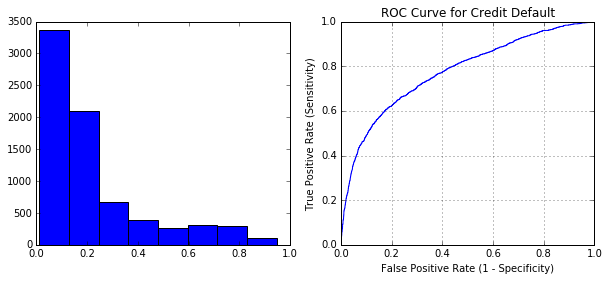

In [185]:
gbc = GradientBoostingClassifier(learning_rate = 0.1, subsample = 0.8, n_estimators=260, random_state=4, max_depth = 4, min_samples_split = 100, min_samples_leaf = 1, max_features = 'sqrt')
X = d2.drop(['default','LB/TBM'], axis=1)
y = d2['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 4)
gbc.fit(X_train, y_train)
y_pred_proba_gbc = gbc.predict_proba(X_test)[:,1]

import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(1, 2,  figsize=(10,4))
#f1 = plt.figure(1)
ax[0].hist(y_pred_proba, bins = 8)
plt.xlim(0,1)
#f1.show()

#f2 = plt.figure(2)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba_gbc)
plt.title("ROC Curve for Credit Default")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid(True)
ax[1].plot(fpr, tpr)
plt.show()

In [193]:
from sklearn.preprocessing import binarize
y_pred_class = binarize([y_pred_proba], 0.26)[0]
#y_pred_class
print('Null Value Accuracy: ', 1 - data['default'].mean())
print('Accuracy Score: ', metrics.accuracy_score(y_test,y_pred_class))
print('Sensitivity Score: ', metrics.recall_score(y_test, y_pred_class))

Null Value Accuracy:  0.7787999999999999
Accuracy Score:  0.7821333333333333
Sensitivity Score:  0.5825932504440497


In [190]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba_gbc)
# A function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [191]:
evaluate_threshold(0.25)

Sensitivity: 0.5950266429840142
Specificity: 0.8301497160557563


In [192]:
print(metrics.roc_auc_score(y_test,y_pred_proba_gbc))

0.7752771101621342


## **Final Results - Recall Scores **

|  _Recall Scores_ | Original Dataset | Feature Engineered Dataset |
| ------------- | ------------- | ------------- |
| **Baseline Model** | 0.379  | 0.378 |
| **Tuned Model** | 0.418  | 0.403 |
| **Sensitivity Threshold** | 0.585  | 0.582 |
| **Overall Difference** | 0.206  | 0.204 |



